In [5]:
import torch
import inspect
import numpy as np
import matplotlib.pyplot as plotter   # type: ignore[attr-defined]
from transformers import WhisperForConditionalGeneration, WhisperProcessor 

In [2]:
model_id = "openai/whisper-base"    
model = WhisperForConditionalGeneration.from_pretrained(model_id)
processor = WhisperProcessor.from_pretrained(model_id)

In [11]:
print(inspect.getsource(model.model.forward))
# print(inspect.getsource(model.model.forward))


    @auto_docstring
    def forward(
        self,
        input_features: Optional[torch.FloatTensor] = None,
        attention_mask: Optional[torch.LongTensor] = None,
        decoder_input_ids: Optional[torch.LongTensor] = None,
        decoder_attention_mask: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        decoder_head_mask: Optional[torch.Tensor] = None,
        cross_attn_head_mask: Optional[torch.Tensor] = None,
        encoder_outputs: Optional[tuple[tuple[torch.FloatTensor]]] = None,
        past_key_values: Optional[Union[EncoderDecoderCache, tuple[torch.FloatTensor]]] = None,
        decoder_inputs_embeds: Optional[tuple[torch.FloatTensor]] = None,
        decoder_position_ids: Optional[tuple[torch.LongTensor]] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
        cache_position: Op

In [ ]:
for layer in model.model.encoder.layers:        
    layer.self_attn.is_causal = True            # type: ignore[attr-defined]

In [ ]:
audio_5s = torch.randn(16000 * 10).numpy()
audio_7s = np.concatenate([audio_5s, torch.randn(16000 * 6).numpy()])

inputs_5s = processor(audio_5s, sampling_rate=16000, return_tensors="pt") # type: ignore[attr-defined]
inputs_7s = processor(audio_7s, sampling_rate=16000, return_tensors="pt") # type: ignore[attr-defined]

print(f"Mel spectrogram 5s: {inputs_5s.input_features.shape}")
print(f"Mel spectrogram 7s: {inputs_7s.input_features.shape}")

In [ ]:
F, axes = plotter.subplots(5, 1, figsize=(15, 12))

for i in range(5):
    feature_5s = inputs_5s.input_features[0, i, :].numpy()
    feature_7s = inputs_7s.input_features[0, i, :].numpy()
    
    axes[i].plot(feature_5s, label='5s audio', alpha=0.7, linewidth=1)
    axes[i].plot(feature_7s, label='7s audio', alpha=0.7, linewidth=1)
    axes[i].set_title(f'Mel Frequency Bin {i}')
    axes[i].set_xlabel('Time Frame')
    axes[i].set_ylabel('Mel Value')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plotter.tight_layout()
plotter.show()

In [ ]:
feature_5s = inputs_5s.input_features
feature_7s = inputs_7s.input_features

In [ ]:
# channels_before_attention   = feature_5s.shape[-1] // 2    # 3000 → 1500 after conv

# causal    = torch.tril(torch.ones(channels_before_attention, channels_before_attention))

# attn_mask = torch.where(causal == 1,
#                         torch.tensor(0.0),
#                         torch.tensor(float("-inf"))
#                        )[None, None, :, :]     

# attn_mask = attn_mask.to(dtype=model.model.encoder.embed_positions.weight.dtype)

# model.eval()
# # Generate transcription
# with torch.no_grad():
#     latents_5s = model.model.encoder(feature_5s, attention_mask=attn_mask)
#     latents_7s = model.model.encoder(feature_7s, attention_mask=attn_mask)

In [ ]:
# Process both through the encoder
with torch.no_grad():
    latents_5s = model.model.encoder(feature_5s)
    latents_7s = model.model.encoder(feature_7s)

In [26]:
latents_5s_tensor = latents_5s.last_hidden_state
latents_7s_tensor = latents_7s.last_hidden_state

print(f"5s latents shape: {latents_5s_tensor.shape}")
print(f"7s latents shape: {latents_7s_tensor.shape}")

5s latents shape: torch.Size([1, 1500, 512])
7s latents shape: torch.Size([1, 1500, 512])


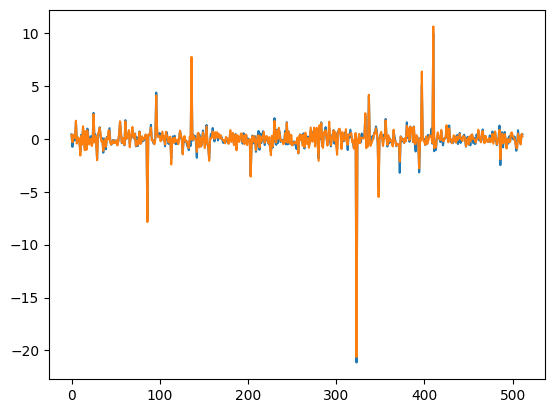

In [28]:
plotter.plot(latents_5s_tensor[0, 1099, :])
plotter.plot(latents_7s_tensor[0, 1099, :])
plotter.show()

In [23]:
for i in range(1500):
    l1 = latents_5s_tensor[0][i]
    l2 = latents_7s_tensor[0][i]
    if not np.allclose(l1, l2):
        print(i)
        break

499


In [ ]:
print(latents_5s_tensor[0][150])
print("hello")
print(latents_7s_tensor[0][450])

### Wav2Vec

In [ ]:
import inspect
print(inspect.getsource(model.model.encoder.forward))

In [ ]:
model_id = "facebook/w2v-bert-2.0"
model = Wav2Vec2BertModel.from_pretrained(model_id)

In [ ]:
print(model.forward)

In [ ]:
print(f"Number of encoder layers: {len(model.encoder.layers)}")

lennn = 500

audio_5s = torch.randn((1, 4, 160))
audio_7s = np.concatenate((audio_5s.numpy(), torch.randn((1, 4, 160)).numpy()), axis=1)
audio_7s = torch.from_numpy(audio_7s)

print(f"A: {audio_5s.shape}")
print(f"Long tensor shape: {audio_7s.shape}")

In [ ]:
with torch.no_grad():
    o1 = model(audio_5s)
    o2 = model(audio_7s)

In [ ]:
print(o1.last_hidden_state.shape)
print(o2.last_hidden_state.shape)

o1h = o1.last_hidden_state
o2h = o2.last_hidden_state

In [ ]:
for i in range(4):
    print(o1h[0][i])
    print(o2h[0][i])
    print("--------------------------------")